In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
epochs = 5
batch_size = 50

In [3]:
# Each training data point will be length 100-1,
# since the last value in each sequence is the label
sequence_length = 100

In [5]:
def generate_model():
  model_RNN = tf.keras.models.Sequential([tf.keras.layers.LSTM(100, return_sequences=True),
                                       tf.keras.layers.LSTM(100, activation='relu'),
                                       tf.keras.layers.Dense(128),
                                       tf.keras.layers.Dense(1)
                                  ])
  model_RNN.compile(loss="mse", optimizer="adam")
  return model_RNN

In [6]:
def normalize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [7]:
def prepare_data(data, train_start, train_end, test_start, test_end):
    print("Length of Data", len(data))

    # training data
    print("Creating training data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Training data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Test data shape  : {}".format(result.shape))

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [8]:
def run(model=None, data=None):
    global_start_time = time.time()

    print('Loading data... ')
    data_b = pd.read_csv('iot-util.csv',
                         parse_dates=[0], infer_datetime_format=True)
    data = data_b['cpu'].to_numpy()

    # train on first 500 samples and test on last 160 samples (test set has anomaly)
    X_train, y_train, X_test, y_test = prepare_data(data, 0, 600, 400, 660)
    
    if model is None:
        model = generate_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, epochs=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test, verbose=1)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print('Training duration:{}'.format(time.time() - global_start_time))
        return model, y_test, 0

    try:
        plt.figure(figsize=(20,8))
        plt.plot(y_test[:len(y_test)], 'b', label='Observed')
        plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
        plt.plot(((y_test - predicted) ** 2), 'r', label='Root-mean-square deviation')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    print('Training duration:{}'.format(time.time() - global_start_time))

    return model, y_test, predicted

Loading data... 
Length of Data 660
Creating training data...
Training data shape  :  (500, 100)
Creating test data...
Test data shape  : (160, 100)
Shape X_train (500, 99)
Shape X_test (160, 99)
Training...
Epoch 1/5
10/10 [==============================] - 7s 311ms/step - loss: 0.5057 - val_loss: 0.1711
Epoch 2/5
10/10 [==============================] - 2s 221ms/step - loss: 0.1854 - val_loss: 0.1667
Epoch 3/5
10/10 [==============================] - 2s 244ms/step - loss: 0.1335 - val_loss: 0.1417
Epoch 4/5
10/10 [==============================] - 2s 223ms/step - loss: 0.1221 - val_loss: 0.1115
Epoch 5/5
10/10 [==============================] - 2s 240ms/step - loss: 0.1195 - val_loss: 0.1112
Predicting...
5/5 [==============================] - 1s 19ms/step
Reshaping predicted


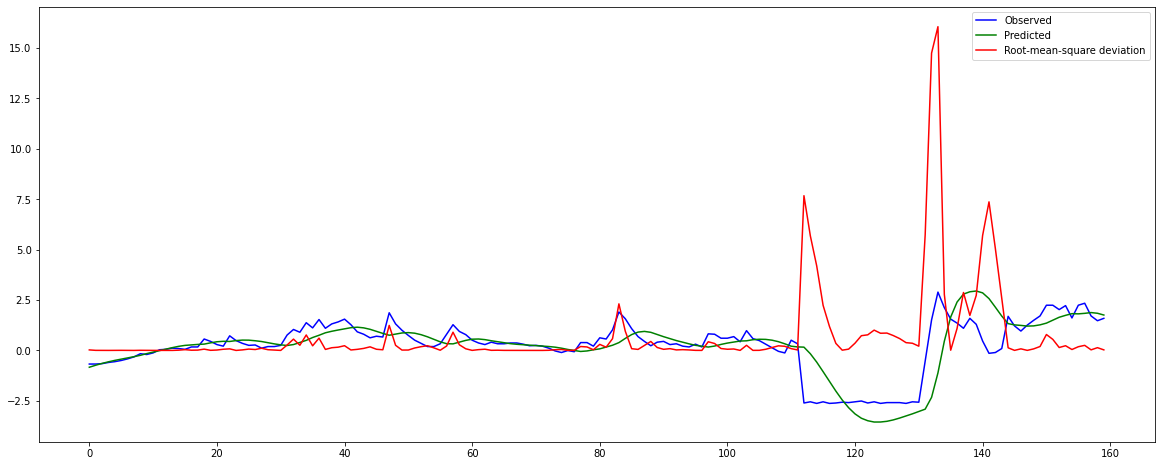

Training duration:18.3094162940979


In [9]:
model, y_test, predicted = run()

In [10]:
#anomaly threshold of 5 chosen based on empirical analyses
start_time = 0
threshold = 5
for i in range(0, len(predicted)-1):
    if ((y_test[i] - predicted[i]) ** 2) > threshold:
        print("Anomaly at time", start_time+i, "RMSE value:", (y_test[i] - predicted[i]) ** 2)
    i = i+1

Anomaly at time 112 RMSE value: 7.67496283629409
Anomaly at time 113 RMSE value: 5.685969144976077
Anomaly at time 131 RMSE value: 5.737776851010587
Anomaly at time 132 RMSE value: 14.748169266711814
Anomaly at time 133 RMSE value: 16.058523278862616
Anomaly at time 140 RMSE value: 5.701007081214678
Anomaly at time 141 RMSE value: 7.369210825594088
Anomaly at time 142 RMSE value: 5.048689965804947
